In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import rioxarray

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

In [6]:
import geopandas as gpd
from deafrica_tools.spatial import xr_rasterize
serengeti = gpd.read_file('data/serengeti.geojson')
serengeti = serengeti.to_crs('epsg:21036')
serengeti
#mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds_rf)

#mask the rainfall dataset
#ds_rf = ds_rf.where(mask)

# Plot the mask
#mask.plot()

,ID,AREA,PERIMETER,ACRES,HECTARES,NAME,Status,Protection,geometry
0,0,654692200.0,177073.1,0.0,0.0,Lemek,Group Ranch,Buffer,"MULTIPOLYGON (((496436.722 9767480.112, 496433..."


In [7]:
# Open the NetCDF file using xarray
ds = xr.open_dataset('data/Serengeti_tamsat.nc')
ds = ds.sel(time=slice('2015-01', '2022-09'))
#ds

In [8]:
ds.rio.set_spatial_dims('lon','lat',inplace=True)
ds.rio.write_crs('EPSG:4326',inplace=True)
ds = ds.rio.reproject("EPSG:21036")
ds

<xarray.Dataset>
Dimensions:      (x: 136, y: 134, time: 2830)
Coordinates:
  * x            (x) float64 3.872e+05 3.914e+05 ... 9.446e+05 9.487e+05
  * y            (y) float64 1e+07 9.996e+06 9.992e+06 ... 9.451e+06 9.447e+06
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2022-09-30
    spatial_ref  int64 0
Data variables:
    rfe          (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    rfe_filled   (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
Attributes:
    Conventions:  CF-1.6
    CreatedBy:    EDAL Libraries
    MoreInfo:     https://github.com/Reading-eScience-Centre/edal-java

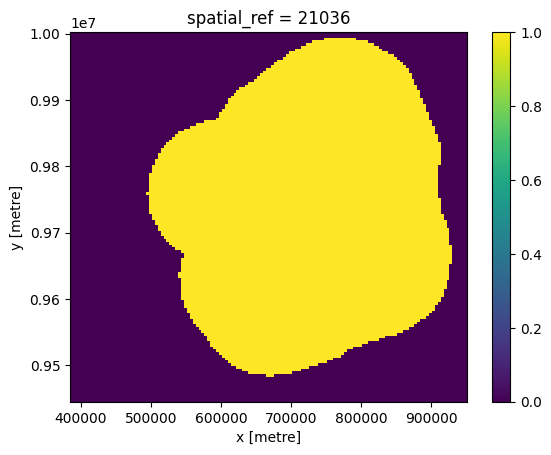

In [9]:
mask = xr_rasterize(serengeti[serengeti['ID'] == 0], ds)

#mask the rainfall dataset
ds = ds.where(mask)

# Plot the mask
mask.plot()

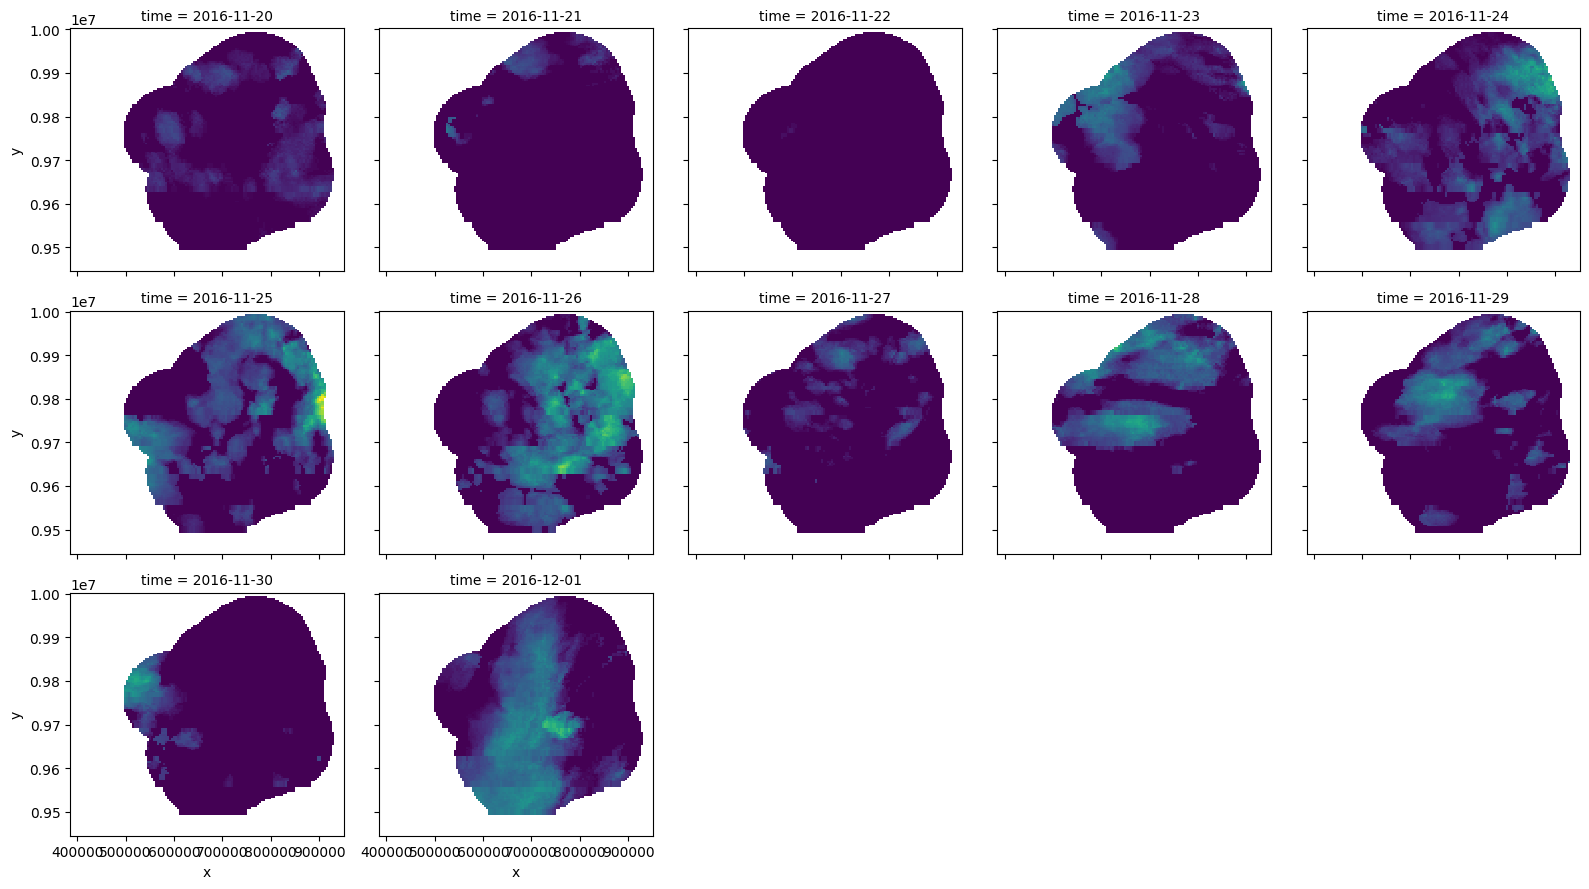

In [11]:
ds.rfe.sel(time=slice('2016-11-20', '2016-12-01')).plot(col='time', col_wrap=5, add_colorbar=False )

In [15]:
# Define the threshold value
threshold = 0.0

# Find the time, latitude, and longitude when rainfall is above the threshold
ds_masked = ds['rfe'].where(ds['rfe'] > threshold, drop=True)
ds_masked

<xarray.DataArray 'rfe' (time: 2690, y: 102, x: 104)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 4.995e+05 5.037e+05 5.079e+05 ... 9.238e+05 9.279e+05
  * y        (y) float64 9.992e+06 9.988e+06 9.984e+06 ... 9.51e+06 9.505e+06
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2022-09-30
Attributes:
    units:          mm
    standard_name:  Rainfall Estimate
    long_name:      Rainfall Estimate

In [13]:
file = "data/Serengeti_all.csv"
dfa = pd.read_csv(file, dtype=None)

dfa['time1'] = pd.to_datetime(dfa['t1_'])
dfa['date1'] = pd.to_datetime(dfa['time1'].dt.date)
dfa['time2'] = pd.to_datetime(dfa['t2_'])
dfa['date2'] = pd.to_datetime(dfa['time2'].dt.date)

# Subset the DataFrame by the date range
dfa.set_index('date1', inplace=True)
dfa = dfa.sort_index()
#df = df['2013-11-11':'2013-11-16']

In [7]:
dfa.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,lat,long,sex,migrant,timestamp_hour,burst_,t1_,t2_,dt_,nsd_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,time1,time2,date2
date1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,SW33,734300.7,736467.200000,9655292.0,9.664024e+06,8996.751983,0.706566,WB,-3.119238,35.108984,F,migrant,2015-01-02T04:00:00Z,1,2015-01-02T03:30:00Z,2015-01-03T03:30:00Z,86400,5.830325e+08,True,3,0.760596,9.104619,1.309078,4742.591587,0.711237,0,2015-01-02 03:30:00+00:00,2015-01-03 03:30:00+00:00,2015-01-03
2015-01-02,SW26,782206.9,773457.746278,9683701.0,9.677025e+06,11005.554990,-2.677442,WB,-2.861518,35.539191,F,migrant,2015-01-02T04:00:00Z,1,2015-01-02T03:30:00Z,2015-01-03T03:30:00Z,86400,3.182860e+08,False,3,-0.894202,9.306155,1.220040,3938.724724,0.842029,0,2015-01-02 03:30:00+00:00,2015-01-03 03:30:00+00:00,2015-01-03
2015-01-02,SW26,782206.9,783160.773637,9683701.0,9.683900e+06,974.419986,0.018042,WB,-2.861518,35.539191,F,migrant,2015-01-02T04:00:00Z,1,2015-01-02T03:30:00Z,2015-01-03T03:30:00Z,86400,3.182860e+08,False,3,0.999837,6.881842,1.220040,3938.724724,0.842029,0,2015-01-02 03:30:00+00:00,2015-01-03 03:30:00+00:00,2015-01-03
2015-01-02,SW26,782206.9,787823.332036,9683701.0,9.681848e+06,5914.064402,-0.506281,WB,-2.861518,35.539191,F,migrant,2015-01-02T04:00:00Z,1,2015-01-02T03:30:00Z,2015-01-03T03:30:00Z,86400,3.182860e+08,False,3,0.874554,8.685089,1.220040,3938.724724,0.842029,0,2015-01-02 03:30:00+00:00,2015-01-03 03:30:00+00:00,2015-01-03
2015-01-02,SW26,782206.9,783164.063292,9683701.0,9.687867e+06,4274.614769,1.157286,WB,-2.861518,35.539191,F,migrant,2015-01-02T04:00:00Z,1,2015-01-02T03:30:00Z,2015-01-03T03:30:00Z,86400,3.182860e+08,False,3,0.401826,8.360449,1.220040,3938.724724,0.842029,0,2015-01-02 03:30:00+00:00,2015-01-03 03:30:00+00:00,2015-01-03


/tmp/ipykernel_237048/85174987.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('magma', len(unique_ids))


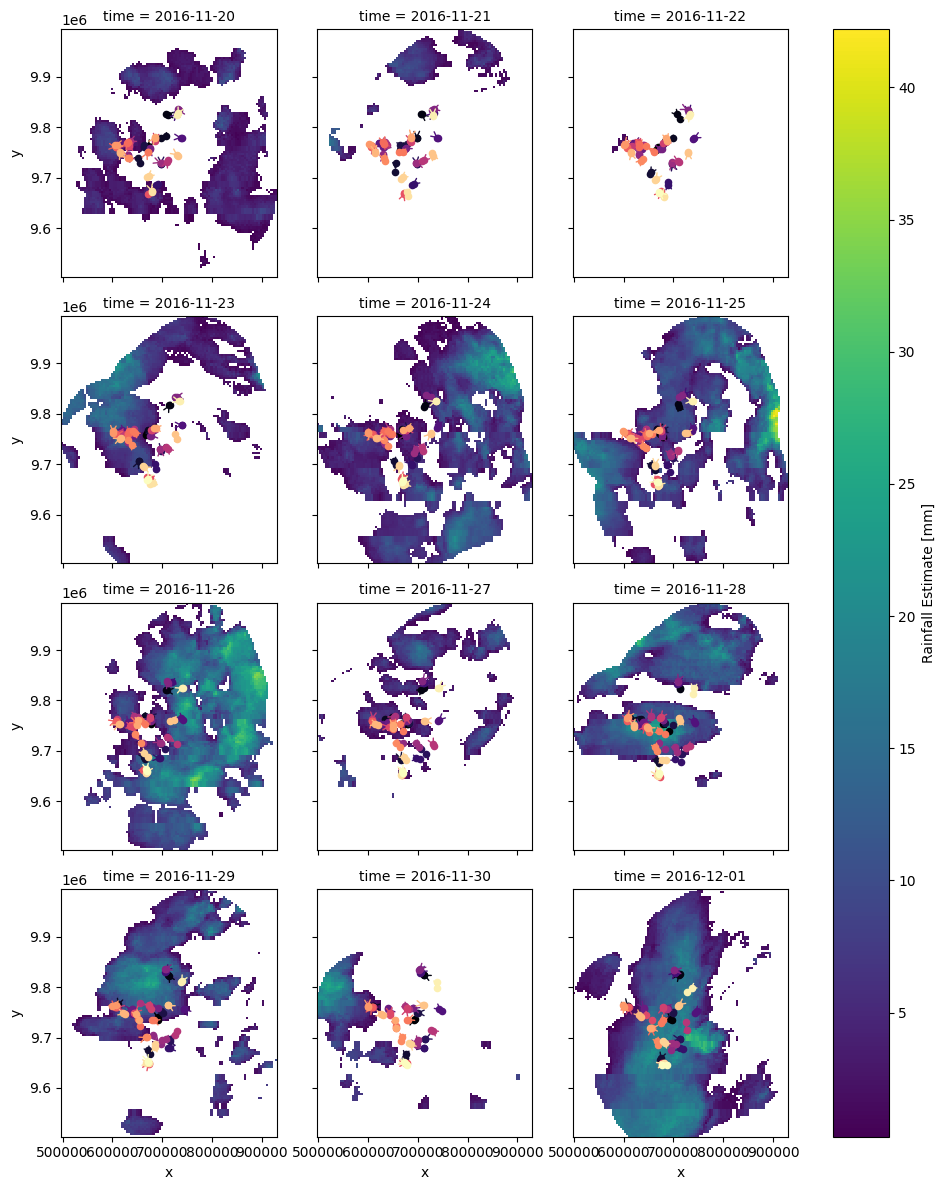

In [16]:
from matplotlib.patches import FancyArrowPatch

dfs = dfa['2016-11-20':'2016-12-01']
dm = ds_masked.sel(time=slice('2016-11-20', '2016-12-01'))
dm.plot(col='time', col_wrap=3 )

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
unique_ids = dfs['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        gps_data_subset = dfs.loc[dfs.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color=color, label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color=color, s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        
        # Set the x and y axis limits for zooming
        #ax.set_xlim(596742, 821598)
        #ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()


In [17]:
dfs = dfa['2016-11-20':'2016-12-01']
dm = ds_masked.sel(time=slice('2016-11-20', '2016-12-01'))

In [35]:
## datasets for cloud calculation
#df = dfa.reset_index()
df = dfs.reset_index()
#rain = ds_masked.to_dataframe().reset_index()
rain = dm.to_dataframe().reset_index()
#rain = dm
rain = rain.dropna()
rain['date'] = pd.to_datetime(rain['time'].dt.date)

df2 = rain#.reset_index()

In [19]:
df.head()

,date1,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,lat,long,sex,migrant,timestamp_hour,burst_,t1_,t2_,dt_,nsd_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,time1,time2,date2
0,2016-11-20,SZ19,672153.8,681268.761724,9762669.0,9.763212e+06,9131.138958,1.878993,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.303341,9.119446,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21
1,2016-11-20,SZ19,672153.8,670312.600000,9762669.0,9.760117e+06,3146.858980,-0.376330,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,True,177,0.930020,8.054160,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21
2,2016-11-20,SZ19,672153.8,672130.959904,9762669.0,9.763331e+06,662.699113,-2.858458,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.960184,6.496321,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21
3,2016-11-20,SZ19,672153.8,665117.422857,9762669.0,9.769882e+06,10076.796849,-2.119945,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.521961,9.217991,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21
4,2016-11-20,SZ19,672153.8,675461.603514,9762669.0,9.758968e+06,4963.947986,0.977986,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,0.558694,8.509957,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21


In [24]:
df2

<xarray.DataArray 'rfe' (time: 12, y: 102, x: 104)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x        (x) float64 4.995e+05 5.037e+05 5.079e+05 ... 9.238e+05 9.279e+05
  * y        (y) float64 9.992e+06 9.988e+06 9.984e+06 ... 9.51e+06 9.505e+06
  * time     (time) datetime64[ns] 2016-11-20 2016-11-21 ... 2016-12-01
Attributes:
    units:          mm
    standard_name:  Rainfall Estimate
    long_name:      Rainfall Estimate

# Find best cloud pixel based on distance and estimated rainfall

In [26]:
import numpy as np
import xarray as xr
from shapely.geometry import Point
from shapely.ops import nearest_points

# Sample data - replace this with your actual cloud and GPS data
cloud_data = df2
gps_data = df

# Function to calculate distance between two points in UTM coordinates
def calculate_distance(point1, point2):
    return point1.distance(point2)

# Iterate through GPS data and find the nearest cloud pixel
best_cloud_pixels = []

for index, gps_row in gps_data.iterrows():
    gps_point = Point(gps_row['x1_'], gps_row['y1_'])
    cloud_slice = cloud_data.sel(time=slice(gps_row['date1']))

    distances = np.zeros_like(cloud_slice)
    for x in range(cloud_slice.shape[0]):
        for y in range(cloud_slice.shape[1]):
            cloud_point = Point(cloud_slice['x'][x].values, cloud_slice['y'][y].values)
            distances[x, y] = calculate_distance(gps_point, cloud_point)

    # Calculate weights based on the inverse of distance
    weights = 1 / (distances + 1e-10)  # Adding a small epsilon to avoid division by zero

    # Find the indices of the maximum weight
    max_indices = np.unravel_index(np.argmax(weights), weights.shape)

    # Retrieve the corresponding cloud pixel values
    best_cloud_pixel = {
        'x': cloud_slice['x'][max_indices[0]].values,
        'y': cloud_slice['y'][max_indices[1]].values,
        'time': gps_row['date1'],
        'rfe': cloud_slice[max_indices].values
    }

    best_cloud_pixels.append(best_cloud_pixel)

# Convert the result to a DataFrame or handle it as needed
best_cloud_pixels_df = pd.DataFrame(best_cloud_pixels)
print(best_cloud_pixels_df)



                      x                  y       time   rfe
0      499535.922194949  9754911.806388792 2016-11-20   nan
1      499535.922194949  9754911.806388792 2016-11-20   nan
2      499535.922194949  9754911.806388792 2016-11-20   nan
3      499535.922194949  9754911.806388792 2016-11-20   nan
4      499535.922194949  9754911.806388792 2016-11-20   nan
5      499535.922194949  9754911.806388792 2016-11-20   nan
6      499535.922194949   9825617.07240733 2016-11-20   nan
7      499535.922194949   9825617.07240733 2016-11-20   nan
8      499535.922194949  9754911.806388792 2016-11-20   nan
9      499535.922194949  9784025.739455247 2016-11-20   nan
10     499535.922194949   9825617.07240733 2016-11-20   nan
11     499535.922194949   9825617.07240733 2016-11-20   nan
12     499535.922194949   9825617.07240733 2016-11-20   nan
13     499535.922194949   9825617.07240733 2016-11-20   nan
14     499535.922194949   9825617.07240733 2016-11-20   nan
15     499535.922194949   9825617.072407

In [ ]:
import numpy as np

def calculate_angle(gps_trajectory, cloud_pixel):
    trajectory_vector = np.array(gps_trajectory[-1]) - np.array(gps_trajectory[0])
    cloud_vector = np.array(cloud_pixel) - np.array(gps_trajectory[0])

    dot_product = np.dot(trajectory_vector, cloud_vector)
    norm_product = np.linalg.norm(trajectory_vector) * np.linalg.norm(cloud_vector)

    angle_rad = np.arccos(dot_product / norm_product)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

angle = calculate_angle(gps_data[['utm_x', 'utm_y']].values, best_cloud_pixel)
print(f"Angle between GPS trajectory and best cloud pixel: {angle} degrees")


In [67]:
import multiprocessing
from tqdm import tqdm
import pandas as pd

def inverse_distance_weights(gps_point, cloud_coords, power=2):
    distances = cdist([gps_point], cloud_coords)
    weights = 1 / (distances ** power)
    normalized_weights = weights / weights.sum()
    return normalized_weights

def find_best_cloud(row, cloud_data):
    subset = cloud_data[cloud_data['date'] == row['date1']]

    if len(subset) == 0:
        return None  # Return None if there are no matching clouds
    
    # Convert NumPy array to list
    gps_point = [row['x1_'], row['y1_']]
    weights = inverse_distance_weights(gps_point, subset[['x', 'y']].values)

    valid_clouds = []
    for i, weight in enumerate(weights):
        if subset['rfe'][i].iloc[i] > 0:
            valid_clouds.append((i, weight))

    valid_clouds.sort(key=lambda x: x[1], reverse=True)

    if len(valid_clouds) > 0:
        best_cloud_index = valid_clouds[0][0]
        best_cloud = subset.iloc[best_cloud_index]
        return best_cloud
    else:
        return None

def process_data(row, cloud_data):
    cloud = find_best_cloud(row, cloud_data)
    if cloud is not None:
        return [cloud['x'].item(), cloud['y'].item(), cloud['rfe'].item()]
    else:
        return [None, None, None]

def process_dataframe(df, cloud_data):
    nearest_clouds = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing df1'):
        cloud_info = process_data(row, cloud_data)
        nearest_clouds.append(cloud_info)

    nearest_cloud_df = pd.DataFrame(nearest_clouds, columns=['best_cloud_x', 'best_cloud_y', 'best_cloud_rainfall'])
    
    return nearest_cloud_df 




Processing df1:   0%|          | 0/4290 [00:00<?, ?it/s]

Processing df1:   0%|          | 0/4290 [00:00<?, ?it/s]


KeyError: 0

In [68]:
if __name__ == '__main__':
    num_processes = multiprocessing.cpu_count()  # Use all available CPU cores

    # Assume you have already loaded your cloud data into a DataFrame named cloud_data
    # cloud_data = pd.read_csv('cloud_data.csv')
    
    # Replace the line above with loading your actual cloud data
    cloud_data = df2

    # Reset the index of your DataFrame
    df.reset_index(drop=True, inplace=True)

    # Process the whole dataset
    df_result = process_dataframe(df, cloud_data)

Processing df1:   0%|          | 0/4290 [00:00<?, ?it/s]


KeyError: 0

In [63]:
df_result.head()

,date1,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,lat,long,sex,migrant,timestamp_hour,burst_,t1_,t2_,dt_,nsd_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,time1,time2,date2,best_cloud_x,best_cloud_y,best_cloud_rainfall
0,2016-11-20,SZ19,672153.8,681268.761724,9762669.0,9.763212e+06,9131.138958,1.878993,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.303341,9.119446,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21,NaN,NaN,NaN
1,2016-11-20,SZ19,672153.8,670312.600000,9762669.0,9.760117e+06,3146.858980,-0.376330,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,True,177,0.930020,8.054160,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21,NaN,NaN,NaN
2,2016-11-20,SZ19,672153.8,672130.959904,9762669.0,9.763331e+06,662.699113,-2.858458,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.960184,6.496321,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21,NaN,NaN,NaN
3,2016-11-20,SZ19,672153.8,665117.422857,9762669.0,9.769882e+06,10076.796849,-2.119945,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,-0.521961,9.217991,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21,NaN,NaN,NaN
4,2016-11-20,SZ19,672153.8,675461.603514,9762669.0,9.758968e+06,4963.947986,0.977986,ZB,-2.149118,34.548751,F,migrant,2016-11-20T05:00:00Z,2,2016-11-20T04:30:00Z,2016-11-21T04:30:00Z,86400,3.774223e+09,False,177,0.558694,8.509957,1.118931,3989.960423,0.24884,0,2016-11-20 04:30:00+00:00,2016-11-21 04:30:00+00:00,2016-11-21,NaN,NaN,NaN


In [9]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from tqdm import tqdm
import multiprocessing
from functools import partial

def find_nearest_clouds(row, df2, threshold_mm):
    subset = df2[df2['date'] == row['date1']]
    
    if len(subset) == 0:
        return None  # Return None if there are no matching clouds
    
    distances = cdist(np.array([[row['x1_'], row['y1_']]]), subset[['x', 'y']], metric='euclidean')
    
    valid_clouds = []
    for i, distance in enumerate(distances[0]):
        if subset.iloc[i]['rfe'] > threshold_mm: #and distance <= max_distance_m:
            valid_clouds.append((i, distance))
    
    valid_clouds.sort(key=lambda x: x[1])
    
    if len(valid_clouds) > 0:
        cloud = subset.iloc[valid_clouds[0][0]]
        return cloud
    else:
        return None

def process_threshold(threshold_mm, df, df2):
    nearest_clouds = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc=f'Processing df1 (Threshold {threshold_mm})'):
        cloud = find_nearest_clouds(row, df2, threshold_mm=threshold_mm)
        if cloud is not None:
            nearest_clouds.append([cloud['x'], cloud['y'], cloud['rfe']])
        else:
            nearest_clouds.append([None, None, None])

    nearest_cloud_df = pd.DataFrame(nearest_clouds, columns=[f'cloud_{threshold_mm}mm_x', f'cloud_{threshold_mm}mm_y', f'cloud_{threshold_mm}mm_rfe'])
    
    return nearest_cloud_df

def calculate_turning_angles_for_threshold(args):
    index, row, threshold_mm = args  # Unpack the tuple to get the index, row, and threshold
    
    # Calculate vectors for trajectory and direction towards the cloud
    trajectory_vector = np.array([row['x2_'] - row['x1_'], row['y2_'] - row['y1_']])
    cloud_vector = np.array([row[f'cloud_{threshold_mm}mm_x'] - row['x1_'], row[f'cloud_{threshold_mm}mm_y'] - row['y1_']])
    
    # Calculate dot product and magnitudes
    dot_product = np.dot(trajectory_vector, cloud_vector) 
    magnitude_trajectory = np.linalg.norm(trajectory_vector)
    magnitude_cloud = np.linalg.norm(cloud_vector)
    
    # Calculate the angle in radians
    if magnitude_trajectory != 0 and magnitude_cloud != 0:
        cos_angle = dot_product / (magnitude_trajectory * magnitude_cloud)
        if cos_angle > 1:
            cos_angle = 1  # To handle potential rounding errors
        elif cos_angle < -1:
            cos_angle = -1  # To handle potential rounding errors
        cloud_angle_radians = np.arccos(cos_angle)
    else:
        cloud_angle_radians = 0  # Handle division by zero or zero-magnitude vectors
 
    cloud_angle_degrees = np.degrees(cloud_angle_radians)
    
    # Calculate difference in turning angles
   # ta_diff = row['ta_'] - turning_angle_cloud_radians
    #angle_difference = (ta_diff + np.pi) % (2 * np.pi) - np.pi

    return dot_product, magnitude_cloud, cloud_angle_radians, cloud_angle_degrees




In [66]:
# Example: Run process_data on a single chunk
test_chunk = chunks[0]
result_for_test_chunk = process_data(test_chunk, cloud_data)
print(result_for_test_chunk)


Processing chunk: 100%|██████████| 357/357 [00:00<00:00, 951.21it/s] 

       best_cloud_x  best_cloud_y  best_cloud_rainfall date1
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN           NaN                  NaN   NaT
991             NaN     

In [10]:
if __name__ == '__main__':
    thresholds = [5,10,15]
    num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
    # Split the DataFrame into chunks for parallel processing
    #chunk_size = len(df) #// num_processes
    #chunk_size = 200
    #chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    
    pool = multiprocessing.Pool(processes=num_processes)
    results = pool.starmap(process_threshold, [(threshold, df, df2) for threshold in thresholds])
    pool.close()
    pool.join()

    # Concatenate the results from different processes
    df = pd.concat([df] + results, axis=1)

    threshold_results = {}

    for threshold_mm in thresholds:
        with multiprocessing.Pool(processes=num_processes) as pool:
            args_list = [(index, row, threshold_mm) for index, row in df.iterrows()]
            turning_angle_results = list(tqdm(pool.map(calculate_turning_angles_for_threshold, args_list), total=len(df), desc=f'Calculating Turning Angles (Threshold {threshold_mm}mm)'))

        #direction_to_cloud_list, trajectory_vector_list, dot_product_list, magnitude_trajectory_list, magnitude_direction_to_cloud_list#, turning_angle_cloud_radians_list, turning_angle_cloud_degrees_list, angle_difference_list = zip(*turning_angle_results)
        dot_product_list, magnitude_cloud_list, cloud_angle_radians_list, cloud_angle_degrees_list = zip(*turning_angle_results)
        
        # Add the results to the original DataFrame with column names indicating the threshold
        df[f'dot_product_{threshold_mm}mm'] = dot_product_list
        df[f'magnitude_cloud_{threshold_mm}mm'] = magnitude_cloud_list
        df[f'cloud_angle_radians_{threshold_mm}mm'] = cloud_angle_radians_list
        df[f'cloud_angle_degrees_{threshold_mm}mm'] = cloud_angle_degrees_list

        threshold_results[threshold_mm] = {
            'dot_product': dot_product_list,
            'magnitude_cloud': magnitude_cloud_list,
            'cloud_angle_radians': cloud_angle_radians_list,
            'cloud_angle_degrees' : cloud_angle_degrees_list,
        }


    # You can access the results for each threshold from the `threshold_results` dictionary
    # Example: threshold_results[5]['turning_angle_cloud_degrees']


Processing df1 (Threshold 15):  40%|████      | 285611/708488 [37:40:33<186:54:29,  1.59s/it]

KeyboardInterrupt: 

Processing df1 (Threshold 15):  41%|████      | 286947/708488 [38:06:13<160:11:00,  1.37s/it]

Below code just calculates the turning angle calculations

In [9]:
file = "data/Serengeti_data2.csv"
df = pd.read_csv(file, dtype=None)

df['time1'] = pd.to_datetime(df['t1_'])
df['date1'] = pd.to_datetime(df['time1'].dt.date)
df['time2'] = pd.to_datetime(df['t2_'])
df['date2'] = pd.to_datetime(df['time2'].dt.date)


df.set_index('date1', inplace=True)
df = df.sort_index()
df = df.reset_index()

df2 = rain#.reset_index()

In [10]:
if __name__ == '__main__':
    thresholds = [5,10,15]
    num_processes = multiprocessing.cpu_count()  # Use all available CPU cores
    # Split the DataFrame into chunks for parallel processing
    #chunk_size = len(df) #// num_processes
    #chunk_size = 200
    #chunks = [df[i:i + chunk_size] for i in range(0, len(df), chunk_size)]
    
    threshold_results = {}

    for threshold_mm in thresholds:
        with multiprocessing.Pool(processes=num_processes) as pool:
            args_list = [(index, row, threshold_mm) for index, row in df.iterrows()]
            turning_angle_results = list(tqdm(pool.map(calculate_turning_angles_for_threshold, args_list), total=len(df), desc=f'Calculating Turning Angles (Threshold {threshold_mm}mm)'))

        #direction_to_cloud_list, trajectory_vector_list, dot_product_list, magnitude_trajectory_list, magnitude_direction_to_cloud_list#, turning_angle_cloud_radians_list, turning_angle_cloud_degrees_list, angle_difference_list = zip(*turning_angle_results)
        dot_product_list, magnitude_cloud_list, cloud_angle_radians_list, cloud_angle_degrees_list = zip(*turning_angle_results)
        
        # Add the results to the original DataFrame with column names indicating the threshold
        df[f'dot_product_{threshold_mm}mm'] = dot_product_list
        df[f'magnitude_cloud_{threshold_mm}mm'] = magnitude_cloud_list
        df[f'cloud_angle_radians_{threshold_mm}mm'] = cloud_angle_radians_list
        df[f'cloud_angle_degrees_{threshold_mm}mm'] = cloud_angle_degrees_list

        threshold_results[threshold_mm] = {
            'dot_product': dot_product_list,
            'magnitude_cloud': magnitude_cloud_list,
            'cloud_angle_radians': cloud_angle_radians_list,
            'cloud_angle_degrees' : cloud_angle_degrees_list,
        }


    # You can access the results for each threshold from the `threshold_results` dictionary
    # Example: threshold_results[5]['turning_angle_cloud_degrees']


Calculating Turning Angles (Threshold 15mm): 100%|██████████| 91025/91025 [00:00<00:00, 5172137.77it/s]


In [11]:
df.head()

,date1,ID,site,x1_,x2_,y1_,y2_,sl_,ta_,lat,long,sex,migrant,owner,CRS,temperature,timestamp_hour,region,burst_,t1_,t2_,dt_,nsd_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,long_1,lat_1,long_2,lat_2,time1,time2,date2,cloud_5mm_x,cloud_5mm_y,cloud_5mm_rfe,cloud_10mm_x,cloud_10mm_y,cloud_10mm_rfe,cloud_15mm_x,cloud_15mm_y,cloud_15mm_rfe,magnitude_cloud_5mm,cloud_angle_radians_5mm,cloud_angle_degrees_5mm,magnitude_cloud_10mm,cloud_angle_radians_10mm,cloud_angle_degrees_10mm,magnitude_cloud_15mm,cloud_angle_radians_15mm,cloud_angle_degrees_15mm,dot_product_5mm,dot_product_10mm,dot_product_15mm
0,2016-10-01,SW37,Serengeti_migrant,729854.3,731488.500000,9859411,9.859506e+06,1636.958961,-2.703445,-1.273826,35.066457,F,migrant,HOPCRAFT,21036,NaN,2016-10-01T05:00:00Z,Serengeti,6,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,1.730275e+10,True,537,-0.905539,7.400596,1.221351,3911.209397,0.562367,0,35.066457,-1.273826,35.081136,-1.272955,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,765720.453088,9.892163e+06,5.3,778197.852974,9.892163e+06,10.3,778197.852974,9.912959e+06,15.2,48570.442434,0.681982,39.074663,58393.544635,0.537390,30.790194,72142.038145,0.778364,44.596963,6.172393e+07,8.211449e+07,8.409008e+07
1,2016-10-01,SW44,Serengeti_migrant,725936.6,727693.076840,9803341,9.802987e+06,1791.697932,0.362231,-1.780813,35.031739,F,migrant,HOPCRAFT,21036,NaN,2016-10-01T05:00:00Z,Serengeti,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,0.935109,7.490919,1.054638,4084.208240,0.464489,0,35.031739,-1.780813,35.047525,-1.783992,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,715810.853546,9.771548e+06,5.3,778197.852974,9.892163e+06,10.3,798993.519450,9.896322e+06,17.0,33366.210431,1.680523,96.286890,103056.405365,1.237573,70.907709,118249.070926,1.103435,63.222149,-6.546559e+06,6.039598e+07,9.545279e+07
2,2016-10-01,SW44,Serengeti_migrant,725936.6,725898.885933,9803341,9.803300e+06,55.353319,-1.759539,-1.780813,35.031739,F,migrant,HOPCRAFT,21036,NaN,2016-10-01T05:00:00Z,Serengeti,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,-0.187625,4.013737,1.054638,4084.208240,0.464489,0,35.031739,-1.780813,35.031400,-1.781180,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,715810.853546,9.771548e+06,5.3,778197.852974,9.892163e+06,10.3,798993.519450,9.896322e+06,17.0,33366.210431,0.441247,25.281606,103056.405365,2.923842,167.523795,118249.070926,3.057980,175.209355,1.670031e+06,-5.569807e+06,-6.522612e+06
3,2016-10-01,SW44,Serengeti_migrant,725936.6,726069.601854,9803341,9.802465e+06,886.370174,-0.859336,-1.780813,35.031739,F,migrant,HOPCRAFT,21036,NaN,2016-10-01T05:00:00Z,Serengeti,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,0.652941,6.787135,1.054638,4084.208240,0.464489,0,35.031739,-1.780813,35.032943,-1.788735,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,715810.853546,9.771548e+06,5.3,778197.852974,9.892163e+06,10.3,798993.519450,9.896322e+06,17.0,33366.210431,0.458957,26.296280,103056.405365,2.459140,140.898319,118249.070926,2.325001,133.212759,2.651427e+07,-7.088714e+07,-7.176607e+07
4,2016-10-01,SW44,Serengeti_migrant,725936.6,733702.995515,9803341,9.798577e+06,9110.902540,0.010656,-1.780813,35.031739,F,migrant,HOPCRAFT,21036,NaN,2016-10-01T05:00:00Z,Serengeti,2,2016-10-01T04:30:00Z,2016-10-02T04:30:00Z,86400,3.163550e+09,False,130,0.999943,9.117227,1.054638,4084.208240,0.464489,0,35.031739,-1.780813,35.101571,-1.823802,2016-10-01 04:30:00+00:00,2016-10-02 04:30:00+00:00,2016-10-02,715810.853546,9.771548e+06,5.3,778197.852974,9.892163e+06,10.3,798993.519450,9.896322e+06,17.0,33366.210431,1.328949,76.143152,103056.405365,1.589148,91.051447,118249.070926,1.455009,83.365887,7.280617e+07,-1.722967e+07,1.244654e+08


In [ ]:
df.to_csv('data/Serengeti2.csv', index=False)

In [ ]:
## Plot the nearest cloud of different thresholds
from matplotlib.patches import FancyArrowPatch

#dfs = dfa['2013-11-20':'2013-11-27']
#df.set_index('date1', inplace=True)
#df = df['2016-11-20':'2016-11-27']
dfd = df[df['ID'] == 'SW37']
dfd.set_index('date1', inplace=True)
#dm = ds_masked.sel(time=slice('2016-11-20', '2016-11-27'))
dm.plot(col='time', col_wrap=2 )
#dfcloud = df

# Get the list of axes from the xarray subplot grid
axes = plt.gcf().get_axes()

# Extract unique IDs from the GPS data
#unique_ids = dfs['ID'].unique()
unique_ids = df['ID'].unique()

# Define a mapping between IDs and colors
id_color_map = {}
colors = plt.cm.get_cmap('magma', len(unique_ids))

for i, id in enumerate(unique_ids):
    id_color_map[id] = colors(i)

# Overlay GPS data on each subplot, coloring by ID and case_
for i, ax in enumerate(axes):
    if i < len(dm['time']):  # Check if the index is within bounds
        # Extract the time for the current subplot
        current_time = dm['time'][i].values
        
        # Filter GPS data for the current time using .loc
        #gps_data_subset = dfs.loc[dfs.index == current_time]
        gps_data_subset = dfd.loc[dfd.index == current_time]
        
        # Iterate over unique IDs and plot each group with a unique color
        for id in unique_ids:
            id_subset = gps_data_subset[gps_data_subset['ID'] == id]
            color = id_color_map[id]
            # Separate the data based on 'case_' values
            case_true_data = id_subset[id_subset['case_']]
            case_false_data = id_subset[~id_subset['case_']]
            # Plot the first set of X and Y data (x1_ and y1_) with different colors
            ax.scatter(case_true_data['x1_'], case_true_data['y1_'], color=color, label=f'ID {id} (Case True)', s=20)
            #ax.scatter(case_false_data['x1_'], case_false_data['y1_'], color=color, label=f'ID {id} (Case False)', s=20)
            # Plot the second set of X and Y data (x2_ and y2_) with different colors
            ax.scatter(case_true_data['x2_'], case_true_data['y2_'], color=color, s=20)
            #ax.scatter(case_false_data['x2_'], case_false_data['y2_'], color=color, s=20)
            ax.scatter(case_true_data['cloud_5mm_x'], case_true_data['cloud_5mm_y'], color='red', s=20)
            #ax.scatter(case_true_data['cloud_8mm_x'], case_true_data['cloud_8mm_y'], color='green', s=20)
            #ax.scatter(case_true_data['cloud_10mm_x'], case_true_data['cloud_10mm_y'], color='yellow', s=20)
            #ax.scatter(case_true_data['cloud4_x'], case_true_data['cloud4_y'], color='orange', s=20)
            #ax.scatter(case_true_data['cloud5_x'], case_true_data['cloud5_y'], color='brown', s=20)
            # Connect the points with lines for both sets of data
            for index, row in case_true_data.iterrows():
                ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             arrowstyle='->', color=color, mutation_scale=10))
            #for index, row in case_false_data.iterrows():
                #ax.add_patch(FancyArrowPatch((row['x1_'], row['y1_']), (row['x2_'], row['y2_']),
                                             #arrowstyle='->', color='grey', mutation_scale=15))
        # Set the x and y axis limits for zooming
        ax.set_xlim(596742, 821598)
        ax.set_ylim(9608997.0, 9879023)
        #ax.legend()
        #ax.set_title(f'GPS Data Overlay at Time {current_time}')

# Show the plot
plt.show()
